In [0]:
import pandas as pd
import os
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
from wordcloud import WordCloud
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
#This dataset has been cleaned 
train = pd.read_csv('train.tsv', sep='\t')
validation = pd.read_csv('valid.tsv', sep='\t')
colnames = ['file', 'tag', 'news', 'topic', 'speaker', 'speaker_job', 'speaker_state','speaker_party', 'ch_false','ch_barelytrue','ch_halftrue','ch_mostlytrue','ch_pantsonfire', 'Spoke_at' ]
train.columns = colnames
validation.columns = colnames
train.drop('file', axis = 1, inplace = True)
validation.drop('file', axis = 1, inplace = True)
liardata = pd.concat([train,validation])

In [0]:
print(train.shape)
print(validation.shape)

(10239, 13)
(1283, 13)


### Exploratory Data Analysis

half-true      2362
false          2257
mostly-true    2213
barely-true    1890
true           1845
pants-fire      955
Name: tag, dtype: int64


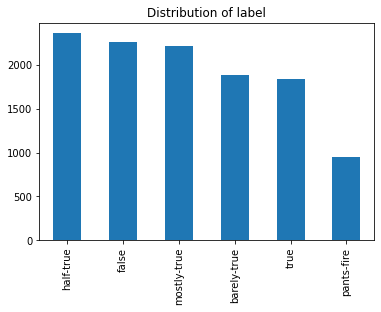

In [0]:
valcounts = liardata.tag.value_counts()
print(valcounts)#/len(liardata)
valcounts.plot(kind = 'bar')
plt.title('Distribution of label')
plt.show()

546 2


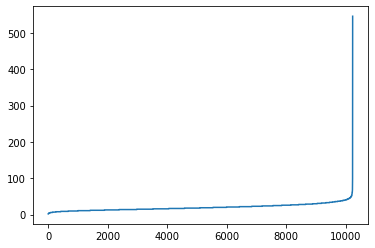

In [0]:
lengths = []
for text in train.news:
  lengths.append(len(nltk.word_tokenize(text)))
print(max(lengths), min(lengths))
lengths.sort()
plt.plot(lengths)

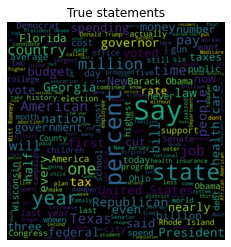

In [0]:
truedf = liardata[liardata.tag == 'true']
large = ''
for text in truedf.news:
  large = large + ' ' + text 
wordcloud = WordCloud(width=800, height=800, margin=0, max_font_size=100, min_font_size=10).generate(large)
 
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('True statements')
plt.margins(x=0, y=0)
plt.show()


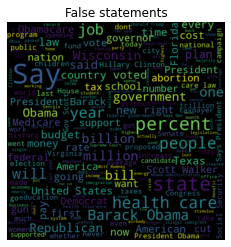

In [0]:
falsedf = liardata[liardata.tag == 'false']
large_f = ''
for text in falsedf.news:
  large_f = large_f + ' ' + text 
wordcloud = WordCloud(width=800, height=800, margin=0, max_font_size=100, min_font_size=10).generate(large_f)
 
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('False statements')
plt.margins(x=0, y=1)
plt.show()

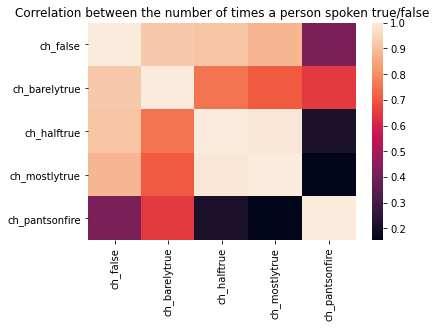

In [0]:
#For each speaker, checking the correlation between the type of information he/she has given
tagcounts = liardata[['ch_false','ch_barelytrue','ch_halftrue','ch_mostlytrue','ch_pantsonfire']]
corr = tagcounts.corr()
plt.title('Correlation between the number of times a person spoken true/false')
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

### Result Interpretation

In [0]:
resultsfile = pd.read_csv('baselineResults.csv')

In [0]:
resultsfile['truth'].value_counts()

false          263
mostly-true    251
half-true      248
barely-true    236
true           169
pants-fire     116
Name: truth, dtype: int64

In [0]:
resultsfile['tfidf_lr'].value_counts()

half-true      276
false          274
mostly-true    271
barely-true    202
true           195
pants-fire      65
Name: tfidf_lr, dtype: int64

In [0]:
print(display_labels)

['pants-fire', 'false', 'half-true', 'true', 'barely-true', 'mostly-true']


[[32 31 11  5 20 17]
 [19 82 44 29 47 42]
 [ 6 52 63 37 35 55]
 [ 1 23 36 46 16 47]
 [ 4 50 63 31 51 37]
 [ 3 36 59 47 33 73]]


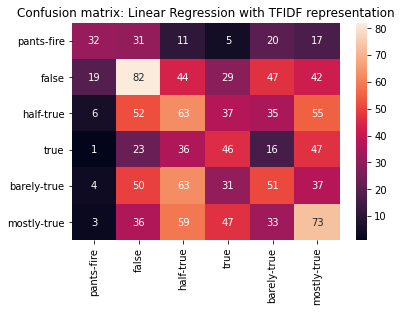

In [0]:
display_labels = list(resultsfile['truth'].unique())
cm = confusion_matrix(resultsfile['truth'], resultsfile['tfidf_lr'], display_labels)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in display_labels], columns = [i for i in display_labels])
#plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title("Confusion matrix: Linear Regression with TFIDF representation")
plt.show()

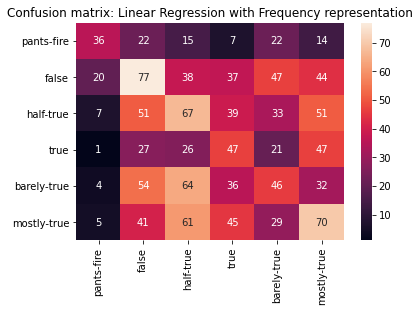

In [0]:
cm = confusion_matrix(resultsfile['truth'], resultsfile['freq_lr'], display_labels)
df_cm = pd.DataFrame(cm, index = [i for i in display_labels], columns = [i for i in display_labels])
#plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title("Confusion matrix: Linear Regression with Frequency representation")
plt.show()

Gather all the records which are misclassified by all the classifiers

In [0]:
cols = ['truth', 'freq_lr', 'binary_lr', 'tfidf_lr']
misclassified = resultsfile[~(resultsfile[cols].eq(resultsfile[cols[0]], axis=0).all(axis=1))][['text', 'truth', 'freq_lr', 'binary_lr', 'tfidf_lr']]

In [0]:
cols = ['truth', 'freq_lr', 'binary_lr', 'tfidf_lr']
correct = resultsfile[resultsfile[cols].eq(resultsfile[cols[0]], axis=0).all(axis=1)][['text', 'truth', 'freq_lr', 'binary_lr', 'tfidf_lr']]

In [0]:
missentences = []
for text in misclassified.text:
  missentences.append(' '.join(text.split("', '")[1:-1]))
misclassified['sentences'] = missentences

Observe the length of distribution for the text in each correctly classified vs misclassified data points

average length of misclassified sentence is 84.66731517509727


(array([ 41., 216., 282., 220., 134.,  74.,  43.,  11.,   4.,   3.]),
 array([ 13. ,  35.7,  58.4,  81.1, 103.8, 126.5, 149.2, 171.9, 194.6,
        217.3, 240. ]),
 <a list of 10 Patch objects>)

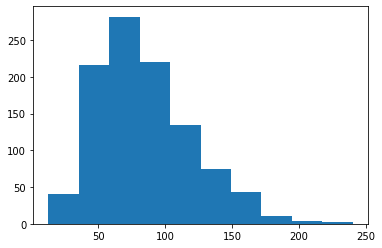

In [0]:
lengths = []
for sent in missentences:
  lengths.append(len(sent))
print('average length of misclassified sentence is {}'.format(sum(lengths)/len(lengths)))
lengths.sort()
plt.hist(lengths)

average length of correctly sentence is 81.98039215686275


(array([ 4., 38., 73., 56., 45., 20.,  9.,  6.,  3.,  1.]),
 array([  4. ,  26.5,  49. ,  71.5,  94. , 116.5, 139. , 161.5, 184. ,
        206.5, 229. ]),
 <a list of 10 Patch objects>)

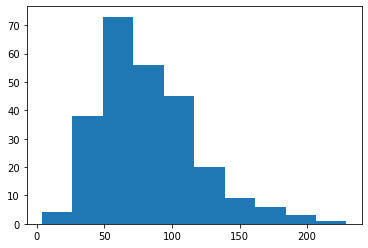

In [0]:
corrects = []
for text in correct.text:
  corrects.append(' '.join(text.split("', '")[1:-1]))
lengths = []
for sent in corrects:
  lengths.append(len(sent))
print('average length of correctly sentence is {}'.format(sum(lengths)/len(lengths)))
lengths.sort()
plt.hist(lengths)

Sample from the misclassified statements per each class label

In [0]:
labels = ['true', 'false', 'half-true', 'mostly-true', 'barely-true', 'pants-fire']
for l in labels:
  samp =  misclassified.loc[misclassified['truth'] == l]['sentences']
  lists = sample(list(set(samp)),10)
  print('----------', l)
  for va in lists:
    print(va)  

---------- true
fact , ##s state funding education today time
commission form government definitely losing favor united states
one man opposed flawed strategy iraq . one man courage call change . one man', "'", 'play politics truth
state budget include scholarship money minority students concession senate democrats supporting go ##p - initiated transportation bill
bill eliminate delta air lines jet fuel tax breaks violate ##s federal law puts state risk losing critical funding federal aviation administration
walton family , owns wal - mart , controls fortune equal wealth bottom 42 percent americans combined
bill mcc ##oll ##um voted four times raise pay , total $ 51 , 000 , earn ##s congressional pension worth $ 75 , 000 year
houston third - toxic city united states america
public display long rifle perfectly legal texas
obama admitted cap trade plan would cause electricity bills sky ##rock ##et
---------- false
says gov . chris christie ##s proposed budget biggest spending budget hist